In [1]:
!pip install playwright>=1.52.0
!pip install "pyee>=13,<14"
!playwright install


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# -*- coding: utf-8 -*-
"""update_new_agent.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/145Id3PJuVVyNw4QHr5U97IXKP5c0KELv
"""

# src/multi_agents/graph/state.py

from typing import TypedDict, List, Dict, Any, Optional, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    # User request
    original_query: str

    # Planning & history
    plan: List[Dict[str, Any]]
    past_steps: List[Dict[str, Any]]

    # Intelligence Stores
    aggregated_results: Dict[str, Any]
    airbnb_host_data: Optional[Dict[str, Any]]

    # Final report (filled by ReportSynthesizer)
    final_report: str

    # Conversation buffer for the graph
    messages: Annotated[List[BaseMessage], add_messages]

    # Transient values passed between nodes
    last_step_result: Optional[Dict[str, Any]]
    last_step_message: Optional[BaseMessage]

    # Human-in-the-loop (HITL) - Kept for future extension
    awaiting_user_confirmation: bool
    candidate_options: List[Dict[str, Any]]
    selected_candidate: Optional[Dict[str, Any]]

    # NEW: Step tracking and control fields
    current_step: int
    max_steps: int
    executed_tasks: List[str]  # Track what tasks have been attempted
    failed_approaches: List[str]  # Track failed strategies to avoid repetition

### `workers_prompts.py`

"""
This file contains the master prompts and persona descriptions for the specialist worker agents.
"""


BASE_WORKER_PROMPT = """
# IDENTITY & MISSION
You are a specialist OSINT Field Agent named {name}. You are a vital component of a larger multi-agent intelligence team. Your mission is to execute your assigned task with precision and generate actionable intelligence for your fellow agents.
{persona}

INVESTIGATION PROGRESS: Step {current_step} of {max_steps} as a max step.

# TEAM CONTEXT & OVERALL OBJECTIVE
The team's primary mission is to answer this query: "{original_query}" with the following information snapshot about the airbnb host as ground truth. Do not contradict it and do not infer fields that aren't present.
<info>
{airbnb_host_data}
</info>

# INVESTIGATION STATE AWARENESS
<Previously_Executed_Tasks>
{executed_tasks}
</Previously_Executed_Tasks>

<Failed_Approaches_To_Avoid>
{failed_approaches}
</Failed_Approaches_To_Avoid>

<Current_Intelligence_Gathered>
{aggregated_results}
</Current_Intelligence_Gathered>

# YOUR CURRENT ASSIGNMENT
The Mission Commander (Supervisor) has deployed you with the following specific task: "{task}"
You must use your specialized tools to fulfill this task. Your success will be measured by both the quality of your direct answer and the new leads you generate for the team.
# STRATEGIC DIRECTIVES FOR SUCCESS
1. **AVOID REPETITION**: Do NOT repeat any previously executed tasks from the list above
2. **AVOID SEARCH ON AIRBNB**: Do not search on airbnb becouse the <info></info> is scraped from airbnb.
2. **LEARN FROM FAILURES**: Avoid approaches that have already failed
3. **BUILD ON SUCCESS**: Leverage existing intelligence to find NEW leads and identities
4. **HIGH-VALUE TARGETS**: Prioritize finding:
   - Real names and aliases
   - Social media profiles with verification potential
   - Business/professional connections
   - Location-specific information
   - Contact details (email, phone)

# FRAMEWORK & OUTPUT
You must operate using the ReAct (Reason-Act-Observe) framework.

**TOOLS:**
------
{tools}

**OUTPUT FORMAT:**
------
To use a tool, you **MUST** use this exact format:
```
Thought: [Your reasoning about the next action based on the task and available data.]
Action: [the name of the tool to use from this list: {tool_names}]
Action Input: [the input to the tool, which can be a string or a JSON object]
```

After you write `Action Input:`, **stop your message immediately** and wait for the tool result (Observation).

When you have fulfilled your task, provide your final answer in the ReAct `Final Answer:` format. Your answer should be a comprehensive summary of your findings and any new leads discovered.

RULES:
- You may ONLY call tools from this exact list: {tool_names}.
- All facts in your Final Answer must come directly from tool outputs.
- If a tool returns an error, try an alternative tool or report the failure in your Final Answer.

Final Answer:
[Your comprehensive summary and list of new leads.]
"""

# --- Persona Descriptions for Each Specialist Worker ---

WEB_SEARCH_INVESTIGATOR_PERSONA = """
Your specialization is **Digital Reconnaissance**. You are an expert in using search engines and web scraping to uncover digital footprints. Your mission is to find social media profiles, public records, news articles, and any other online information related to the target based on names, locations, and other keywords provided by the Supervisor.
"""

IMAGE_SEARCH_INVESTIGATOR_PERSONA = """
Your specialization is **Visual Intelligence (VISINT)**. You are an expert in reverse image searching and facial recognition. Your mission is to take a profile picture and find every other instance of it online, identifying associated profiles on social media, forums, and other websites to link identities across platforms.
"""

Social_Media_Investigator_PERSONA = """
Your specialization is **Social Network Intelligence (SOCMINT)**. You are an expert in extracting intelligence from social media platforms. 
Your mission is to uncover the target’s online presence by finding and analyzing social media accounts, posts, comments, images, and interactions. 
You excel at identifying patterns of behavior, networks of friends or associates, and verifying identities across platforms. 
Your role is to connect digital breadcrumbs into a coherent picture of the host’s real-world identity, business activity, and communication channels.
"""


REPORT_SYNTHESIZER_PROMPT = """You are the team's dedicated Intelligence Analyst and Report Synthesizer. Your mission is to transform the final, aggregated intelligence findings into a comprehensive, well-structured, and human-readable final report for the end-user.

Original Query: {original_query}


Database Ground Truth:
{airbnb_host_data}


Aggregated Intelligence Findings:
{aggregated_results}

Create a clean, professional Markdown report. Start with a high-level summary of the investigation's conclusions, followed by detailed sections for each key finding (e.g., Social Media Presence, Contact Information, Location History, etc.). Be thorough and precise.
"""

from typing import Dict, Any, Optional, cast
from langchain.agents import AgentExecutor, Tool
from langchain.agents import create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from multi_agents.tools import search_tools
from multi_agents.constants.constants import Constants
import logging
from langchain_core.messages import AIMessage
from pydantic import SecretStr
import json

# from multi_agents.Prompts.workers_prompts import (
#     BASE_WORKER_PROMPT,
#     WEB_SEARCH_INVESTIGATOR_PERSONA,
#     IMAGE_SEARCH_INVESTIGATOR_PERSONA,
#     REPORT_SYNTHESIZER_PROMPT,
# )


class BaseWorker:
    def __init__(self, tools: list, name: str, system_prompt_extension: str):
        self.llm = ChatOpenAI(
            model=Constants.WORKER_MODEL,
            temperature=0.0,
            base_url=Constants.OPENROUTER_BASE_URL,
            api_key=SecretStr(Constants.OPENROUTER_API_KEY or "")
        )
        self.tools = tools
        self.name = name
        self.logger = logging.getLogger(__name__)

        prompt = ChatPromptTemplate.from_messages([
            ("system", BASE_WORKER_PROMPT),
            ("human", "{input}"),
            ("ai", "{agent_scratchpad}")
        ])

        prompt = prompt.partial(
            tools="\n".join([f"{tool.name}: {tool.description}" for tool in tools]),
            tool_names=", ".join([tool.name for tool in tools]),
            name=self.name,
            persona=system_prompt_extension
        )

        self.agent = create_react_agent(self.llm, tools, prompt)
        self.agent_executor = AgentExecutor(
            agent=self.agent,
            tools=tools,
            verbose=True,
            handle_parsing_errors=True,
            max_iterations=8,
        )

    def run(self, state: Dict[str, Any], config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
        try:
            # The input for the worker is now a simple dictionary, often just `{"task": "..."}`
            task_input = state["plan"][0]["inputs"]
            task_string = task_input.get("task", json.dumps(task_input))


            agg_results_str = json.dumps(state.get("aggregated_results", {}), indent=2)

            db_str = json.dumps(state.get("airbnb_host_data", {}), indent=2)

            result = self.agent_executor.invoke({
                "input": task_string,
                "task": task_string,
                "original_query": state["original_query"],
                "aggregated_results": agg_results_str,
                "airbnb_host_data": db_str,
            }, config)

            final_output = result.get("output", f"No specific output from {self.name}.")

            return {
                "last_step_result": {
                    "worker": self.name,
                    "results": {self.name: final_output},
                    "success": True
                },
                "last_step_message": AIMessage(content=f"{self.name} completed its task. Summary: {final_output}")
            }
        except Exception as e:
            self.logger.error(f"{self.name} failed: {str(e)}", exc_info=True)
            return {
                "last_step_result": {
                    "worker": self.name,
                    "results": {},
                    "success": False,
                    "error": str(e)
                },
                "last_step_message": AIMessage(content=f"{self.name} failed with error: {str(e)}")
            }

class WebSearchInvestigator(BaseWorker):
    def __init__(self):
        tools = [
            search_tools.tavily_search,
            search_tools.google_search,
            search_tools.web_scraper,
            search_tools.duckduckgo_search,

            search_tools.yandex_search,
            search_tools.yahoo_search,
            search_tools.baidu_search,

            search_tools.yelp_search,

        ]
        super().__init__(tools, "WebSearchInvestigator", WEB_SEARCH_INVESTIGATOR_PERSONA)

class ImageSearchInvestigator(BaseWorker):
    def __init__(self):
        tools = [
            search_tools.google_lens_search,
            search_tools.bing_images_search,
            search_tools.google_image_search
        ]
        super().__init__(tools, "ImageSearchInvestigator", IMAGE_SEARCH_INVESTIGATOR_PERSONA)


class ReportSynthesizer:
    def __init__(self):
        self.llm = ChatOpenAI(
            model=Constants.SYNTHESIZER_MODEL,
            temperature=0.0,
            base_url=Constants.OPENROUTER_BASE_URL,
            api_key=SecretStr(Constants.OPENROUTER_API_KEY or "")
        )
        self.logger = logging.getLogger(__name__)

    def run(self, state: Dict[str, Any], config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
        prompt = ChatPromptTemplate.from_template(REPORT_SYNTHESIZER_PROMPT)
        chain = prompt | self.llm
        try:
            # Ensure aggregated_results is a string for the prompt
            aggregated_results_str = json.dumps(state.get("aggregated_results", {}), indent=2)

            db_str = json.dumps(state.get("airbnb_host_data", {}), indent=2)
            report = chain.invoke({
                "original_query": state["original_query"],
                "aggregated_results": aggregated_results_str,
                "airbnb_host_data": db_str,
            }, config).content

            self.logger.info("Report successfully generated")
            return {
                "final_report": report,
                "last_step_message": AIMessage(content="Final report generated.")
            }
        except Exception as e:
            self.logger.error(f"Failed to generate report: {str(e)}")
            return {
                "final_report": f"Error generating report: {str(e)}",
                "last_step_message": AIMessage(content=f"Failed to generate report: {str(e)}")
            }

# Multi-Worker System Implementation

import asyncio
from typing import Dict, Any, Optional, List
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
import logging
import json
import re
class Aggregator:
    """
    The responsibility of this class is to receive multiple outputs from multiple workers
    and return the aggregated results.
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)

    def aggregate_results(self, worker_name: str, task_results: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Takes a list of task results and aggregates them into the expected format.

        Args:
            worker_name: Name of the worker type (e.g., "WebSearchInvestigator")
            task_results: List of results from individual tasks

        Returns:
            Aggregated result in the expected format
        """
        try:
            # Combine all results from different tasks
            combined_results = {}
            all_summaries = []

            for task_result in task_results:
                task_name = task_result.get("task", "unknown_task")
                result_content = task_result.get("results", "")

                # Add individual task results
                combined_results[f"{worker_name}_{task_name}"] = result_content
                all_summaries.append(f"Task: {task_name} - Result: {result_content[:200]}...")

            # Create overall summary
            overall_summary = f"{worker_name} completed {len(task_results)} tasks. " + \
                            " | ".join(all_summaries)

            return {
                "last_step_result": {
                    "worker": worker_name,
                    "results": combined_results,
                    "success": True,
                    "task_count": len(task_results),
                    "individual_results": task_results
                },
                "last_step_message": AIMessage(
                    content=f"{worker_name} completed {len(task_results)} tasks. Summary: {overall_summary}"
                )
            }

        except Exception as e:
            self.logger.error(f"Aggregation failed for {worker_name}: {str(e)}", exc_info=True)
            return {
                "last_step_result": {
                    "worker": worker_name,
                    "results": {},
                    "success": False,
                    "error": str(e)
                },
                "last_step_message": AIMessage(
                    content=f"{worker_name} aggregation failed with error: {str(e)}"
                )
            }

SOCIAL_URL_RE = re.compile(
    r"(?:https?://)?(?:[\w\-]+\.)?(?:linkedin\.com|lnkd\.in|instagram\.com|instagr\.am|facebook\.com|fb\.com)\b",
    re.I
)
class MultiWorker:
    """
    This class wraps the worker to receive in the state a planner for a worker with multi tasks.
    It creates worker agents based on the number of inputs and runs them asynchronously.
    """

    def __init__(self, worker_class, worker_name: str):
        self.worker_class = worker_class
        self.worker_name = worker_name
        self.aggregator = Aggregator()
        self.logger = logging.getLogger(__name__)

    async def run_single_task(self, task_input: Dict[str, Any], state: Dict[str, Any],
                             config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
        """
        Run a single task using a worker instance.
        """
        try:
            # Create a worker instance for this task
            worker = self.worker_class()
            # === SOCIAL URL GUARD (skip web_scraper for social domains) ===
            task_string = task_input.get("task", "")
            if self.worker_name == "WebSearchInvestigator" and SOCIAL_URL_RE.search(task_string):
                msg = ("skipped_web_scraper_for_social_domain: route_to SocialMediaInvestigator "
                       "(use linkedin_people_search / instagram_* / facebook_pages_lookup)")
                return {
                    "task": task_string,
                    "results": msg,
                    "success": True
                }
            # Prepare state for single task
            single_task_state = {
                **state,
                "plan": [{"inputs": task_input}]  # Single task plan
            }

            # Run the worker
            result = worker.run(single_task_state, config)

            # Extract the actual result
            worker_result = result.get("last_step_result", {})
            final_output = worker_result.get("results", {}).get(self.worker_name, "No output")

            return {
                "task": task_input.get("task", "unknown"),
                "results": final_output,
                "success": worker_result.get("success", False),
                "error": worker_result.get("error", None)
            }

        except Exception as e:
            self.logger.error(f"Single task execution failed: {str(e)}", exc_info=True)
            return {
                "task": task_input.get("task", "unknown"),
                "results": "",
                "success": False,
                "error": str(e)
            }

    async def run(self, state: Dict[str, Any], config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
        """
        Main run method that executes multiple tasks asynchronously.
        """
        try:
            # Extract inputs from the plan
            plan_step = state["plan"][0]
            task_inputs = plan_step.get("inputs", [])

            if not isinstance(task_inputs, list):
                # Fallback for single task format
                task_inputs = [task_inputs]

            self.logger.info(f"{self.worker_name} received {len(task_inputs)} tasks")

            # Create tasks for async execution
            tasks = []
            for task_input in task_inputs:
                task = self.run_single_task(task_input, state, config)
                tasks.append(task)

            # Execute all tasks asynchronously
            task_results = await asyncio.gather(*tasks, return_exceptions=True)

            # Handle any exceptions that occurred
            processed_results = []
            for i, result in enumerate(task_results):
                if isinstance(result, Exception):
                    processed_results.append({
                        "task": f"task_{i}",
                        "results": "",
                        "success": False,
                        "error": str(result)
                    })
                else:
                    processed_results.append(result)

            # Aggregate results
            return self.aggregator.aggregate_results(self.worker_name, processed_results)

        except Exception as e:
            self.logger.error(f"{self.worker_name} multi-task execution failed: {str(e)}", exc_info=True)
            return {
                "last_step_result": {
                    "worker": self.worker_name,
                    "results": {},
                    "success": False,
                    "error": str(e)
                },
                "last_step_message": AIMessage(
                    content=f"{self.worker_name} failed with error: {str(e)}"
                )
            }


class MultiWebSearchInvestigator(MultiWorker):
    """
    Multi-task wrapper for WebSearchInvestigator
    """

    def __init__(self):
        super().__init__(WebSearchInvestigator, "WebSearchInvestigator")


class MultiImageSearchInvestigator(MultiWorker):
    """
    Multi-task wrapper for ImageSearchInvestigator
    """

    def __init__(self):
        super().__init__(ImageSearchInvestigator, "ImageSearchInvestigator")

# Update to workers.py

class EnhancedBaseWorker(BaseWorker):
    """Enhanced worker with step tracking and anti-repetition logic"""

    def run(self, state: Dict[str, Any], config: Optional[RunnableConfig] = None) -> Dict[str, Any]:
        try:
            task_input = state["plan"][0]["inputs"]
            task_string = task_input.get("task", json.dumps(task_input))

            # Prepare enhanced context
            current_step = state.get("current_step", 1)
            max_steps = state.get("max_steps", 5)
            steps_remaining = max_steps - current_step
            executed_tasks = state.get("executed_tasks", [])
            failed_approaches = state.get("failed_approaches", [])

            agg_results_str = json.dumps(state.get("aggregated_results", {}), indent=2)
            db_str = json.dumps(state.get("airbnb_host_data", {}), indent=2)

            result = self.agent_executor.invoke({
                "input": task_string,
                "task": task_string,
                "original_query": state["original_query"],
                "aggregated_results": agg_results_str,
                "airbnb_host_data": db_str,
                "current_step": current_step,
                "max_steps": max_steps,
                "steps_remaining": steps_remaining,
                "executed_tasks": executed_tasks,
                "failed_approaches": failed_approaches,
            }, config)

            final_output = result.get("output", f"No specific output from {self.name}.")

            return {
                "last_step_result": {
                    "worker": self.name,
                    "results": {self.name: final_output},
                    "success": True,
                    "step": current_step
                },
                "last_step_message": AIMessage(content=f"Step {current_step}/{max_steps} - {self.name}: {final_output}")
            }
        except Exception as e:
            self.logger.error(f"{self.name} failed: {str(e)}", exc_info=True)
            return {
                "last_step_result": {
                    "worker": self.name,
                    "results": {},
                    "success": False,
                    "error": str(e),
                    "step": state.get("current_step", 1)
                },
                "last_step_message": AIMessage(content=f"Step {state.get('current_step', 1)}/{state.get('max_steps', 5)} - {self.name} failed: {str(e)}")
            }

# Enhanced Multi-Worker Classes
class EnhancedMultiWebSearchInvestigator(MultiWorker):
    def __init__(self):
        super().__init__(lambda: EnhancedBaseWorker(
            tools=[
                search_tools.tavily_search, search_tools.google_search,
                search_tools.web_scraper, search_tools.duckduckgo_search,
                search_tools.yandex_search, search_tools.yahoo_search,
                search_tools.baidu_search, search_tools.yelp_search,
            ],
            name="WebSearchInvestigator",
            system_prompt_extension=WEB_SEARCH_INVESTIGATOR_PERSONA
        ), "WebSearchInvestigator")

class EnhancedMultiImageSearchInvestigator(MultiWorker):
    def __init__(self):
        super().__init__(lambda: EnhancedBaseWorker(
            tools=[
                search_tools.google_lens_search,
                search_tools.bing_images_search,
                search_tools.google_image_search
            ],
            name="ImageSearchInvestigator",
            system_prompt_extension=IMAGE_SEARCH_INVESTIGATOR_PERSONA
        ), "ImageSearchInvestigator")


class EnhancedMultiSocialMediaInvestigator(MultiWorker):
    def __init__(self):
        super().__init__(lambda: EnhancedBaseWorker(
            tools=[
                search_tools.linkedin_people_search,
                search_tools.facebook_pages_lookup,

                # Instagram pipeline
                search_tools.instagram_scrape_and_load,
                search_tools.instagram_db_get_posts,
                search_tools.instagram_db_get_images,
                search_tools.instagram_db_get_comments,

                # Breach/phone
                # search_tools.leak_lookup_search,
                search_tools.phone_lookup,
            ],
            name="SocialMediaInvestigator",
            system_prompt_extension=Social_Media_Investigator_PERSONA
        ), "SocialMediaInvestigator")


### `supervisor_prompts.py`

"""
This file contains the master prompts (the "brains") for the Supervisor agent.
It defines the strategic doctrine and decision-making frameworks.
"""
SUPERVISOR_INITIAL_PLAN_PROMPT_ENHANCED = """
You are an expert OSINT investigator beginning a {max_steps}-step investigation mission.

# Mission Parameters
- **Maximum Steps**: {max_steps}
- **Current Step**: 1 of {max_steps}
- **Success Criteria**: Comprehensive identity profile with high confidence verification

# Database Intelligence
Here is the complete data profile for the target:
{host_data}

# Available Agents (Multi-Task Capable)
- `multi_web_search_investigator`: Executes 3-5 complementary web searches simultaneously
- `multi_image_search_investigator`: Executes 3-5 reverse image searches simultaneously
- `multi_social_media_investigator`: Executes 3-5 social media searches simultaneously

# Strategic Planning Doctrine
1. **Maximize Efficiency**: Each step should execute multiple complementary tasks
2. **Intelligence Layering**: Build upon database facts with external verification
3. **High-Probability Approaches**: Prioritize searches most likely to yield positive identification

# STEP 1 STRATEGY
Analyze the database and create 3-4 high-value initial search tasks that cover:
- Name + location combinations
- Unique identifiers (usernames, business names)
- Cross-platform verification searches
- Professional/business record searches

# Output Format
Your plan MUST be a valid JSON array with multiple complementary tasks:

[
  {{
    "agent": "multi_web_search_investigator",
    "inputs": [
      {{"task": "Search for exact name and primary location combination"}},
      {{"task": "Search for business/professional records using available identifiers"}},
      {{"task": "Search for social media profiles using name variations and location"}}
    ]
  }}
]
"""

SUPERVISOR_REASSESS_PLAN_PROMPT_ENHANCED = """
# ROLE & MISSION
You are a Master OSINT (Open Source Intelligence) Strategist and Mission Commander. Your mission is to direct a team of AI specialist agents to create a comprehensive intelligence dossier on a target.

# INVESTIGATIVE DOCTRINE
1.  **Tenacity & Multi-Angle Approach**: Never stop at one piece of evidence. Use every new fact—names, usernames, locations, and URLs—to launch new waves of investigation.
2.  **Information is Fuel**: Analyze the `aggregated_results` from your agents and the initial `airbnb_host_data` to inform your next move.
3.  **Intelligence-Driven Tasking (SOP):**
    - **IF** the initial `web_search_investigator` has run and `image_search_investigator` has NOT, your next step **MUST** be to deploy `image_search_investigator`. Use the `profile_pic_url` from the `airbnb_host_data`, and listenings pictures .
    - **IF** new leads like specific social media URLs are found in `aggregated_results`, deploy `web_search_investigator` again with the `web_scraper` tool to investigate that specific URL.
    - **IF** all leads from both web and image searches have been pursued, your final step **MUST** be to deploy `report_synthesizer`.

# YOUR TEAM OF SPECIALISTS
- `web_search_investigator`: Your primary tool for text-based searches and scraping specific URLs.
- `image_search_investigator`: Your specialist for reverse image searches.
- `report_synthesizer`: Deploys ONLY at the end to compile the final report.

# MISSION COMMAND CENTER
You are the Professional and the best OSINT Strategist investigator managing a {max_steps}-step investigation.
tasks is deferent from the steps (each step contain multi tasks)
# CURRENT STATUS:
- **Current Step**:{current_step}
- **Max Step**:{max_steps}
- **Steps Remaining**:{steps_remaining}
- **Stop Condation**: if Current Step biger then Max Step or You fined the target with the Steps Remaining last then 2.

# INVESTIGATION INTELLIGENCE STATE
- **Original Query**: {original_query}
- **Database Intelligence**: {airbnb_host_data}
- **Executed Tasks**: {executed_tasks}
- **Failed Approaches**: {failed_approaches}
- **Current Intelligence**: {aggregated_results}

# STRATEGIC ASSESSMENT FRAMEWORK
Evaluate the current state and determine the SINGLE most impactful next step:

## If Steps Remaining = 0:
- **MANDATORY**: Deploy `report_synthesizer` immediately
## do YOUR next TASK: DYNAMIC RE-PLANNING
Create the single next best step for the investigation.
1.  **Handle Failures**: If the last step failed, create a new plan that works around the error. Do not repeat the failing step.
2.  **Re-architect for Impact**: If the last step succeeded, use the new `Aggregated Findings` and the `SOP` to build the next logical mission.
3.  **Conclude**: If all leads are exhausted, deploy `report_synthesizer`. If the report is done, return an empty JSON array `[]` to end the mission.


# ANTI-REPETITION PROTOCOLS
**NEVER** repeat these executed tasks: {executed_tasks}
**AVOID** these failed approaches: {failed_approaches}

# MISSION-CRITICAL DECISION TREE
1. **IMAGE SEARCH PRIORITY**: If web searches completed but no image searches executed → Deploy `multi_image_search_investigator`
2. **WEB FOLLOW-UP**: If new URLs/profiles discovered → Deploy targeted `multi_web_search_investigator`
3. **SOCIAL MEDIA EXPLOITATION**: If candidate identities, usernames, emails, or phone numbers are uncovered → Deploy `multi_social_media_investigator` to map social presence, verify authenticity, and extract relational intelligence across platforms.
4. **FINALIZATION**: If investigation complete or steps exhausted → Deploy `report_synthesizer`


# OUTPUT FORMAT
Return a JSON array with a SINGLE step containing multiple strategic tasks:

For multi-task operations:
[
  {{
    "agent": "multi_web_search_investigator",
    "inputs": [
      {{"task": "NEW high-value task based on current intelligence"}},
      {{"task": "Follow-up investigation on discovered leads"}},
      {{"task": "Verification search for identified profiles"}}
    ]
  }}
]

For finalization:
[
  {{
    "agent": "report_synthesizer",
    "inputs": {{}}
  }}
]

For mission completion:
[]
"""


SUPERVISOR_INITIAL_PLAN_PROMPT = """
You are an expert OSINT investigator kicking off a new mission. Your first job is to create the single, most effective first step for your team based on data extracted from an internal database.

# Mission Objective
Analyze the provided Airbnb host data and create the best first task for your team.

# Database Intelligence
Here is the complete data profile for the target, extracted from our database:
{host_data}

# Available Agents
- `web_search_investigator`: Conducts web searches for names, locations, etc.
- `image_search_investigator`: Conducts reverse image searches on URLs.

# Standard Operating Procedure (SOP) for Initial Tasking
1.  **Analyze**: Meticulously analyze the `host_data` to identify the host's name, primary location, and profile picture URL.
2.  **Prioritize**: The highest-value first step is almost always a targeted web search.
3.  **Task Creation**: Your first and only step in the plan MUST be to deploy the `web_search_investigator`.
4.  **Construct Query**: Create a precise task for the agent. For example, if the host is named "Abdel" and is from "Marrakech", the input should be `{{ "task": "Search for 'Abdel from Marrakech' to find social media profiles and business records." }}`.

# Output Format
Your plan MUST be a valid JSON array containing a single step for the `web_search_investigator`.

Example:
[
  {{
    "agent": "agent_name",
    "inputs": {{
      "task": "task details for maximaize the oportenity of find the target and finish investigation"
    }}
  }}
]
"""


SUPERVISOR_REASSESS_PLAN_PROMPT = """
# ROLE & MISSION
You are a Master OSINT (Open Source Intelligence) Strategist and Mission Commander. Your mission is to direct a team of AI specialist agents to create a comprehensive intelligence dossier on a target.

# INVESTIGATIVE DOCTRINE
1.  **Tenacity & Multi-Angle Approach**: Never stop at one piece of evidence. Use every new fact—names, usernames, locations, and URLs—to launch new waves of investigation.
2.  **Information is Fuel**: Analyze the `aggregated_results` from your agents and the initial `airbnb_host_data` to inform your next move.
3.  **Intelligence-Driven Tasking (SOP):**
    - **IF** the initial `web_search_investigator` has run and `image_search_investigator` has NOT, your next step **MUST** be to deploy `image_search_investigator`. Use the `profile_pic_url` from the `airbnb_host_data`, and listenings pictures .
    - **IF** new leads like specific social media URLs are found in `aggregated_results`, deploy `web_search_investigator` again with the `web_scraper` tool to investigate that specific URL.
    - **IF** all leads from both web and image searches have been pursued, your final step **MUST** be to deploy `report_synthesizer`.

# YOUR TEAM OF SPECIALISTS
- `web_search_investigator`: Your primary tool for text-based searches and scraping specific URLs.
- `image_search_investigator`: Your specialist for reverse image searches.
- `report_synthesizer`: Deploys ONLY at the end to compile the final report.

# CURRENT INVESTIGATION STATE
- **Original Query**: {original_query}
- **Initial DB Intelligence**: {airbnb_host_data}
- **Completed Steps & Results**: {past_steps}
- **Aggregated Findings (Latest Intelligence)**: {aggregated_results}

# YOUR TASK: DYNAMIC RE-PLANNING
Create the single next best step for the investigation.
1.  **Handle Failures**: If the last step failed, create a new plan that works around the error. Do not repeat the failing step.
2.  **Re-architect for Impact**: If the last step succeeded, use the new `Aggregated Findings` and the `SOP` to build the next logical mission.
3.  **Conclude**: If all leads are exhausted, deploy `report_synthesizer`. If the report is done, return an empty JSON array `[]` to end the mission.

# OUTPUT FORMAT & RULES
Your response MUST be a valid JSON array containing a SINGLE step.
- Do NOT output any other text or explanations.

Example for [`image_search_investigator`, `web_search_investigator`]:
[
  {{
    "agent": "agent_name",
    "inputs": {{
      "task": "task details for maximaize the oportenity of find the target and finish investigation"
    }}
  }}
]


Example for `report_synthesizer`:
[
  {{
    "agent": "report_synthesizer",
    "inputs": {{}}
  }}
]
"""

# Updated Supervisor Prompts to handle multi-task planning

SUPERVISOR_INITIAL_PLAN_PROMPT_MULTI = """
You are an expert OSINT investigator kicking off a new mission. Your first job is to create multiple effective tasks for your team based on data extracted from an internal database.

# Mission Objective
Analyze the provided Airbnb host data and create the best initial tasks for your team.

# Database Intelligence
Here is the complete data profile for the target, extracted from our database:
{host_data}

# Available Agents
- `multi_web_search_investigator`: Conducts multiple web searches simultaneously
- `multi_image_search_investigator`: Conducts multiple reverse image searches simultaneously
- `multi_social_media_investigator`: Conducts multiple social media searches simultaneously


# Standard Operating Procedure (SOP) for Initial Tasking
1. **Analyze**: Meticulously analyze the `host_data` to identify the host's name, primary location, profile picture URL, and other identifying information.
2. **Multi-Task Strategy**: Create 2-4 complementary search tasks that cover different angles of investigation.
3. **Task Creation**: Your first step should deploy the `multi_web_search_investigator` with multiple targeted searches.
4. **Construct Queries**: Create precise tasks. For example, if the host is named "Abdel" from "Marrakech":
   - Search for the full name and location
   - Search for business records
   - Search for social media profiles
   - Search for any unique identifiers found in the data

# Output Format
Your plan MUST be a valid JSON array containing a single step with multiple inputs for the worker.

Example:
[
  {{
    "agent": "multi_web_search_investigator",
    "inputs": [
      {{"task": "Search for 'Abdel from Marrakech' to find social media profiles"}},
      {{"task": "Search for 'Abdel Marrakech business' to find professional records"}},
      {{"task": "Search for any unique usernames or identifiers found in the host data"}}
    ]
  }}
]
"""

SUPERVISOR_REASSESS_PLAN_PROMPT_MULTI = """
# ROLE & MISSION
You are a Master OSINT (Open Source Intelligence) Strategist and Mission Commander. Your mission is to direct a team of AI specialist agents to create a comprehensive intelligence dossier on a target.

# INVESTIGATIVE DOCTRINE
1. **Tenacity & Multi-Angle Approach**: Never stop at one piece of evidence. Use every new fact—names, usernames, locations, and URLs—to launch new waves of investigation.
2. **Information is Fuel**: Analyze the `aggregated_results` from your agents and the initial `airbnb_host_data` to inform your next move.
3. **Multi-Task Intelligence-Driven Tasking (SOP):**
   - **IF** initial web searches completed and image search hasn't run, deploy `multi_image_search_investigator` with multiple image tasks
   - **IF** new leads like social media username or urls are found, deploy `multi_social_media_investigator` again with targeted scraping tasks
   - **IF** aggregated_results contain LinkedIn / Instagram / Facebook URLs, ALWAYS deploy `multi_social_media_investigator`
   - **IF** new leads like specific URLs are found, deploy `multi_web_search_investigator` again with targeted scraping tasks
   - **IF** all leads have been pursued, deploy `report_synthesizer`

# YOUR TEAM OF SPECIALISTS
- `multi_web_search_investigator`: Executes multiple web searches and scraping tasks simultaneously
- `multi_image_search_investigator`: Executes multiple reverse image searches simultaneously
- `multi_social_media_investigator`: Executes multiple social media searches simultaneously
- `report_synthesizer`: Compiles the final report (single task only)

# CURRENT INVESTIGATION STATE
- **Original Query**: {original_query}
- **Initial DB Intelligence**: {airbnb_host_data}
- **Completed Steps & Results**: {past_steps}
- **Aggregated Findings (Latest Intelligence)**: {aggregated_results}

# YOUR TASK: DYNAMIC RE-PLANNING
Create the single next best step with multiple tasks for maximum investigation efficiency.

# OUTPUT FORMAT & RULES
Your response MUST be a valid JSON array containing a SINGLE step with multiple inputs.

Example for multi-task agents:
[
  {{
    "agent": "multi_web_search_investigator",
    "inputs": [
      {{"task": "Scrape and analyze the Facebook profile found: [URL]"}},
      {{"task": "Search for additional social media using the real name discovered"}},
      {{"task": "Investigate the business connections mentioned in previous results"}}
    ]
  }}
]

Example for report synthesizer (single task):
[
  {{
    "agent": "report_synthesizer",
    "inputs": {{}}
  }}
]
"""

from typing import List, Dict, Any, Optional, cast
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from multi_agents.constants.constants import Constants
from multi_agents.agents.workers import AirbnbAnalyzer
import logging
from pydantic import SecretStr
import json
import re
from multi_agents.database.airbnb_db import AirbnbDB


# from multi_agents.Prompts.supervisor_prompts import (
#     SUPERVISOR_INITIAL_PLAN_PROMPT,
#     SUPERVISOR_REASSESS_PLAN_PROMPT,
# )
# from ..graph.state import AgentState

class Supervisor:
    def __init__(self):
        self.llm = ChatOpenAI(
            model=Constants.SUPERVISOR_MODEL,
            temperature=0.0,
            base_url=Constants.OPENROUTER_BASE_URL,
            api_key=SecretStr(Constants.OPENROUTER_API_KEY or "")
        )
        self.parser = JsonOutputParser()
        self.logger = logging.getLogger(__name__)
        self.db_path = Constants.CONFIG_DB_FILE

        self.retrival = AirbnbAnalyzer()._tool_get_host_all

    # --- Database Extraction Logic (migrated from old AirbnbAnalyzer) ---
    def _db(self) -> AirbnbDB:
        # fresh connection per call => avoids cross-thread sqlite issues
        return AirbnbDB(self.db_path)

    def _parse_user_id(self, s: str) -> Optional[str]:
        if not s:
            return None
        if s.isdigit():
            return s
        m = re.search(r"/users/show/(\d+)", s)
        return m.group(1) if m else None

    def _fetch_profile(self, db: AirbnbDB, host: str) -> Optional[Dict[str, Any]]:
        """Robustly fetches host profile by ID or URL with fallbacks."""
        user_id = self._parse_user_id(host)

        if user_id:
            try:
                cur = db.conn.execute("SELECT * FROM host_tracking WHERE userId = ? ORDER BY rowid DESC LIMIT 1", (user_id,))
                r = cur.fetchone()
                if r: return dict(r)
            except Exception as e:
                self.logger.warning(f"host_tracking by userId failed: {e}")

        if host and host.startswith("http"):
            try:
                cur = db.conn.execute("SELECT * FROM host_tracking WHERE userUrl = ? ORDER BY rowid DESC LIMIT 1", (host,))
                r = cur.fetchone()
                if r: return dict(r)
            except Exception as e:
                self.logger.warning(f"host_tracking by userUrl failed: {e}")
        return None

    def _listings(self, db: AirbnbDB, uid: str) -> List[Dict[str, Any]]:
        try:
            cur = db.conn.execute("SELECT userId, name, listingId, listingUrl FROM host_listings WHERE userId = ? ORDER BY rowid DESC", (uid,))
            return [dict(row) for row in cur.fetchall()]
        except Exception:
            return []

    def _listings_detailed(self, db: AirbnbDB, uid: str) -> List[Dict[str, Any]]:
        try:
            cur = db.conn.execute("SELECT * FROM listing_tracking WHERE userId = ? ORDER BY rowid DESC", (uid,))
            return [dict(row) for row in cur.fetchall()]
        except Exception:
            return []

    def _reviews_all(self, db: AirbnbDB, uid: str) -> List[Dict[str, Any]]:
        try:
            cur = db.conn.execute("SELECT * FROM host_reviews WHERE userId = ? ORDER BY id ASC", (uid,))
            return [dict(row) for row in cur.fetchall()]
        except Exception:
            return []

    def _dedupe_reviews(self, rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        seen = set()
        out = []
        for r in rows:
            key = (r.get("reviewer_name", ""), (r.get("text") or "").strip())
            if key in seen: continue
            seen.add(key)
            out.append(r)
        return out

    def _get_host_all_data(self, host_identifier: str) -> Dict[str, Any]:
        """
        DB-only: given a host id or profile URL, pull EVERYTHING we have for that host from SQLite.
        """
        self.logger.info(f"Attempting to extract all DB data for host: {host_identifier}")
        try:
            host = host_identifier.strip()
            db = self._db()

            profile = self._fetch_profile(db, host)
            if not profile:
                return {"status": "error_not_found", "reason": "host_not_in_db", "input": host}

            uid = str(profile.get("userId") or "")
            if not uid:
                 return {"status": "error_not_found", "reason": "Could not determine userId from profile", "profile": profile}


            listings = self._listings(db, uid)
            listings_detailed = self._listings_detailed(db, uid)
            reviews_raw = self._reviews_all(db, uid) or []
            reviews = self._dedupe_reviews(reviews_raw)

            return {
                "status": "ok",
                "userId": uid,
                "core": profile,
                "listings": listings,
                "listings_detailed": listings_detailed,
                "reviews": reviews,
            }

        except Exception as e:
            self.logger.error(f"Database extraction failed for host '{host_identifier}': {e}", exc_info=True)
            return {"status": "error", "error": str(e)}

    # --- End of Corrected Database Extraction Logic ---


    # --- Planning Logic ---
    def create_initial_plan(self, host_data: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Generate initial investigation plan based on DB data."""
        prompt = ChatPromptTemplate.from_template(SUPERVISOR_INITIAL_PLAN_PROMPT)
        chain = prompt | self.llm | self.parser
        try:
            # Serialize data for the prompt
            host_data_str = json.dumps(host_data, indent=2)
            plan = chain.invoke({"host_data": host_data_str})
            self.logger.info(f"Initial plan created: {plan}")
            return cast(List[Dict[str, Any]], plan)
        except Exception as e:
            self.logger.error(f"Failed to create initial plan: {e}")
            # Fallback plan
            return [{"agent": "web_search_investigator", "inputs": {"task": "General search for the target."}}]

    def reassess_plan(self, state: AgentState) -> List[Dict[str, Any]]:
        """Re-evaluates and updates the investigation plan."""
        prompt = ChatPromptTemplate.from_template(SUPERVISOR_REASSESS_PLAN_PROMPT)
        chain = prompt | self.llm | self.parser
        try:
            # Serialize complex objects for the prompt
            state_for_prompt = {
                **state,
                "airbnb_host_data": json.dumps(state.get("airbnb_host_data"), indent=2),
                "aggregated_results": json.dumps(state.get("aggregated_results"), indent=2),
                "past_steps": json.dumps(state.get("past_steps"), indent=2)
            }
            new_plan = chain.invoke(state_for_prompt)
            self.logger.info(f"Supervisor re-architected the plan: {new_plan}")
            return cast(List[Dict[str, Any]], new_plan)
        except Exception as e:
            self.logger.error(f"Critical failure during plan reassessment: {e}")
            return [] # End the investigation on planning failure

    # --- Router ---
    def route_to_worker(self, state: AgentState) -> str:
        if not state.get("plan"):
            return "end"
        next_agent = state["plan"][0].get("agent")
        if not next_agent:
            self.logger.warning("No agent specified in plan step, ending.")
            return "end"
        return next_agent

    # --- Main Entry Point for the Graph ---
    def run(self, state: AgentState, config: Optional[Any] = None) -> Dict[str, Any]:
        # --- First Run Initialization ---
        if "plan" not in state or state.get("plan") is None:
            self.logger.info("Supervisor running for the first time. Initializing investigation.")
            try:
                host_data = self.retrival(
                    {"host": self._get_host_all_data(state["original_query"])}
                )                                                                                    # self._get_host_all_data(state["original_query"])
                if host_data.get("status") != "ok":
                     return {"messages": [AIMessage(content=f"Fatal Error: Could not extract initial data from DB. Reason: {host_data.get('reason') or host_data.get('error')}")]}
            except Exception as e:
                return {"messages": [AIMessage(content=f"Fatal Error: An exception occurred during DB extraction. {e}")]}

            plan = self.create_initial_plan(host_data)
            return {
                "plan": plan,
                "airbnb_host_data": host_data,
                "past_steps": [],
                "aggregated_results": {},
                "messages": [AIMessage(content="Extracted host data from database and created initial investigation plan.")]
            }

        # --- Subsequent Runs: Process last result and re-plan ---
        last_result = state.get("last_step_result")
        if last_result:
            # Update history and aggregated findings
            new_past_steps = state.get("past_steps", []) + [last_result]
            new_aggregated_results = {**state.get("aggregated_results", {}), **last_result.get("results", {})}

            # Create a temporary state to pass to the planner
            temp_state_for_planning = cast(AgentState, {
                **state,
                "past_steps": new_past_steps,
                "aggregated_results": new_aggregated_results
            })

            # Re-plan based on the new information
            new_plan = self.reassess_plan(temp_state_for_planning)

            return {
                "plan": new_plan,
                "past_steps": new_past_steps,
                "aggregated_results": new_aggregated_results,
                "messages": state.get("messages", []) + [cast(AIMessage, state.get("last_step_message"))],
                "last_step_result": None, # Clear transient state
                "last_step_message": None
            }

        # Should not be reached in normal flow
        return {}

# Updated Supervisor class methods

class SupervisorMulti(Supervisor):
    """
    Updated Supervisor that handles multi-task planning
    """

    def create_initial_plan(self, host_data: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Generate initial investigation plan with multiple tasks based on DB data."""
        prompt = ChatPromptTemplate.from_template(SUPERVISOR_INITIAL_PLAN_PROMPT_MULTI)
        chain = prompt | self.llm | self.parser
        try:
            host_data_str = json.dumps(host_data, indent=2)
            plan = chain.invoke({"host_data": host_data_str})
            self.logger.info(f"Multi-task initial plan created: {plan}")
            return cast(List[Dict[str, Any]], plan)
        except Exception as e:
            self.logger.error(f"Failed to create initial multi-task plan: {e}")
            # Fallback plan with multiple tasks
            return [{
                "agent": "multi_web_search_investigator",
                "inputs": [
                    {"task": "General search for the target"},
                    {"task": "Search for social media profiles"},
                    {"task": "Search for business records"}
                ]
            }]

    def reassess_plan(self, state: AgentState) -> List[Dict[str, Any]]:
        """Re-evaluates and updates the investigation plan with multi-task support."""
        prompt = ChatPromptTemplate.from_template(SUPERVISOR_REASSESS_PLAN_PROMPT_MULTI)
        chain = prompt | self.llm | self.parser
        try:
            state_for_prompt = {
                **state,
                "airbnb_host_data": json.dumps(state.get("airbnb_host_data"), indent=2),
                "aggregated_results": json.dumps(state.get("aggregated_results"), indent=2),
                "past_steps": json.dumps(state.get("past_steps"), indent=2)
            }
            new_plan = chain.invoke(state_for_prompt)
            self.logger.info(f"Supervisor re-architected the multi-task plan: {new_plan}")
            return cast(List[Dict[str, Any]], new_plan)
        except Exception as e:
            self.logger.error(f"Critical failure during multi-task plan reassessment: {e}")
            return []

    def route_to_worker(self, state: AgentState) -> str:
        """Updated router to handle multi-worker agents"""
        if not state.get("plan"):
            return "end"
        next_agent = state["plan"][0].get("agent")
        if not next_agent:
            self.logger.warning("No agent specified in plan step, ending.")
            return "end"

        # Map to multi-worker versions
        agent_mapping = {
            "web_search_investigator": "multi_web_search_investigator",
            "image_search_investigator": "multi_image_search_investigator",
            "social_media_investigator": "multi_social_media_investigator",
            "multi_web_search_investigator": "multi_web_search_investigator",
            "multi_image_search_investigator": "multi_image_search_investigator",
            "multi_social_media_investigator": "multi_social_media_investigator",

            "report_synthesizer": "report_synthesizer"
        }

        return agent_mapping.get(next_agent, next_agent)

class EnhancedSupervisorMulti(SupervisorMulti):
    """
    Enhanced Supervisor with step tracking and anti-repetition logic
    """

    def __init__(self, max_steps: int = 5):
        super().__init__()
        self.max_steps = max_steps

    def _extract_task_signatures(self, executed_steps: List[Dict[str, Any]]) -> List[str]:
        """Extract unique task signatures to avoid repetition"""
        signatures = []
        for step in executed_steps:
            worker = step.get("worker", "")
            if "WebSearch" in worker:
                # Extract search terms/concepts
                results = step.get("results", {})
                for key, value in results.items():
                    if isinstance(value, str) and len(value) > 20:
                        # Extract key search concepts (simplified)
                        if "search" in key.lower():
                            signatures.append(f"web_search:{key[:50]}")
            elif "ImageSearch" in worker:
                signatures.append("image_search:profile_pic")
        return signatures

    def _extract_failed_approaches(self, executed_steps: List[Dict[str, Any]]) -> List[str]:
        """Extract approaches that failed to avoid repetition"""
        failed = []
        for step in executed_steps:
            if not step.get("success", True):
                worker = step.get("worker", "")
                error = step.get("error", "")
                failed.append(f"{worker}:{error[:100]}")
        return failed

    def create_initial_plan(self, host_data: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Generate initial investigation plan with step awareness"""
        prompt = ChatPromptTemplate.from_template(SUPERVISOR_INITIAL_PLAN_PROMPT_ENHANCED)
        chain = prompt | self.llm | self.parser
        try:
            host_data_str = json.dumps(host_data, indent=2)
            plan = chain.invoke({
                "host_data": host_data_str,
                "max_steps": self.max_steps
            })
            self.logger.info(f"Enhanced initial plan created: {plan}")
            return cast(List[Dict[str, Any]], plan)
        except Exception as e:
            self.logger.error(f"Failed to create enhanced initial plan: {e}")
            return [{
                "agent": "multi_web_search_investigator",
                "inputs": [
                    {"task": "Comprehensive name and location search"},
                    {"task": "Social media profile discovery"},
                    {"task": "Business record verification"}
                ]
            }]

    def reassess_plan(self, state: AgentState) -> List[Dict[str, Any]]:
        """Enhanced plan reassessment with step awareness"""
        current_step = state.get("current_step", 1)
        steps_remaining = self.max_steps - current_step
        executed_tasks = self._extract_task_signatures(state.get("past_steps", []))
        failed_approaches = self._extract_failed_approaches(state.get("past_steps", []))

        # Force report synthesis if steps exhausted
        if steps_remaining <= 0:
            return [{"agent": "report_synthesizer", "inputs": {}}]

        prompt = ChatPromptTemplate.from_template(SUPERVISOR_REASSESS_PLAN_PROMPT_ENHANCED)
        chain = prompt | self.llm | self.parser
        try:
            state_for_prompt = {
                **state,
                "airbnb_host_data": json.dumps(state.get("airbnb_host_data"), indent=2),
                "aggregated_results": json.dumps(state.get("aggregated_results"), indent=2),
                "current_step": current_step + 1,
                "max_steps": self.max_steps,
                "steps_remaining": steps_remaining,
                "executed_tasks": executed_tasks,
                "failed_approaches": failed_approaches
            }
            new_plan = chain.invoke(state_for_prompt)
            self.logger.info(f"Enhanced plan reassessment: Step {current_step + 1}/{self.max_steps}, Plan: {new_plan}")
            return cast(List[Dict[str, Any]], new_plan)
        except Exception as e:
            self.logger.error(f"Enhanced plan reassessment failed: {e}")
            # Force completion if planning fails
            return [{"agent": "report_synthesizer", "inputs": {}}]

    def run(self, state: AgentState, config: Optional[Any] = None) -> Dict[str, Any]:
        # Initialize step tracking on first run
        if "current_step" not in state:
            state = {
                **state,
                "current_step": 0,
                "max_steps": self.max_steps,
                "executed_tasks": [],
                "failed_approaches": []
            }

        # First run initialization
        if "plan" not in state or state.get("plan") is None:
            self.logger.info(f"Starting {self.max_steps}-step OSINT investigation")
            try:
                host_data = self.retrival(
                    {"host": self._get_host_all_data(state["original_query"])}
                )
                if host_data.get("status") != "ok":
                    return {"messages": [AIMessage(content=f"Fatal Error: Could not extract initial data from DB. Reason: {host_data.get('reason') or host_data.get('error')}")]}
            except Exception as e:
                return {"messages": [AIMessage(content=f"Fatal Error: DB extraction failed. {e}")]}

            plan = self.create_initial_plan(host_data)
            return {
                **state,
                "plan": plan,
                "airbnb_host_data": host_data,
                "current_step": 1,
                "past_steps": [],
                "aggregated_results": {},
                "messages": [AIMessage(content=f"Initialized {self.max_steps}-step OSINT investigation with database intelligence.")]
            }

        # Process results and increment step counter
        last_result = state.get("last_step_result")
        if last_result:
            new_current_step = state.get("current_step", 1) + 1
            new_past_steps = state.get("past_steps", []) + [last_result]
            new_aggregated_results = {**state.get("aggregated_results", {}), **last_result.get("results", {})}

            # Update task tracking
            executed_tasks = state.get("executed_tasks", [])
            if not last_result.get("success", True):
                failed_approaches = state.get("failed_approaches", [])
                failed_approaches.append(f"Step{new_current_step-1}:{last_result.get('worker', 'unknown')}")
            else:
                failed_approaches = state.get("failed_approaches", [])

            # Create temporary state for planning
            temp_state_for_planning = cast(AgentState, {
                **state,
                "current_step": new_current_step,
                "past_steps": new_past_steps,
                "aggregated_results": new_aggregated_results,
                "executed_tasks": executed_tasks,
                "failed_approaches": failed_approaches
            })

            # Re-plan with step awareness
            new_plan = self.reassess_plan(temp_state_for_planning)

            return {
                **state,
                "plan": new_plan,
                "current_step": new_current_step,
                "past_steps": new_past_steps,
                "aggregated_results": new_aggregated_results,
                "executed_tasks": executed_tasks,
                "failed_approaches": failed_approaches,
                "messages": state.get("messages", []) + [cast(AIMessage, state.get("last_step_message"))],
                "last_step_result": None,
                "last_step_message": None
            }

        return {}

from langgraph.graph import StateGraph, END
from langgraph.pregel import Pregel
# from .state import AgentState
# from ..agents.supervisor import Supervisor
# from ..agents.workers import (
#     WebSearchInvestigator,
#     ImageSearchInvestigator,
#     ReportSynthesizer
# )

class GraphBuilder:
    def __init__(self):
        self.supervisor = Supervisor()
        self.web_search_investigator = WebSearchInvestigator()
        self.image_search_investigator = ImageSearchInvestigator()
        self.report_synthesizer = ReportSynthesizer()

    def build_graph(self) -> Pregel:
        workflow = StateGraph(AgentState)

        # Add nodes
        workflow.add_node("supervisor", self.supervisor.run)
        workflow.add_node("web_search_investigator", self.web_search_investigator.run)
        workflow.add_node("image_search_investigator", self.image_search_investigator.run)
        workflow.add_node("report_synthesizer", self.report_synthesizer.run)

        # Define edges
        workflow.add_edge("web_search_investigator", "supervisor")
        workflow.add_edge("image_search_investigator", "supervisor")
        workflow.add_edge("report_synthesizer", END)

        # Conditional edges from supervisor
        workflow.add_conditional_edges(
            "supervisor",
            self.supervisor.route_to_worker,
            {
                "web_search_investigator": "web_search_investigator",
                "image_search_investigator": "image_search_investigator",
                "report_synthesizer": "report_synthesizer",
                "end": END
            }
        )

        # Set entry point
        workflow.set_entry_point("supervisor")

        return workflow.compile()

# Updated Graph Builder

class MultiGraphBuilder:
    def __init__(self):
        self.supervisor = SupervisorMulti()
        self.multi_web_search_investigator = MultiWebSearchInvestigator()
        self.multi_image_search_investigator = MultiImageSearchInvestigator()
        self.report_synthesizer = ReportSynthesizer()

    def build_graph(self) -> Pregel:
        workflow = StateGraph(AgentState)

        # Add nodes - now with multi-worker support
        workflow.add_node("supervisor", self.supervisor.run)
        workflow.add_node("multi_web_search_investigator", self.multi_web_search_investigator.run)
        workflow.add_node("multi_image_search_investigator", self.multi_image_search_investigator.run)
        workflow.add_node("report_synthesizer", self.report_synthesizer.run)

        # Define edges
        workflow.add_edge("multi_web_search_investigator", "supervisor")
        workflow.add_edge("multi_image_search_investigator", "supervisor")
        workflow.add_edge("report_synthesizer", END)

        # Conditional edges from supervisor
        workflow.add_conditional_edges(
            "supervisor",
            self.supervisor.route_to_worker,
            {
                "multi_web_search_investigator": "multi_web_search_investigator",
                "multi_image_search_investigator": "multi_image_search_investigator",
                "report_synthesizer": "report_synthesizer",
                "end": END
            }
        )

        # Set entry point
        workflow.set_entry_point("supervisor")

        return workflow.compile()

# Enhanced Graph Builder
# Update to builder.py

class EnhancedMultiGraphBuilder:
    def __init__(self, max_steps: int = 5):
        self.supervisor = EnhancedSupervisorMulti(max_steps=max_steps)
        self.multi_web_search_investigator = EnhancedMultiWebSearchInvestigator()
        self.multi_image_search_investigator = EnhancedMultiImageSearchInvestigator()
        self.multi_social_media_investigator = EnhancedMultiSocialMediaInvestigator()
        self.report_synthesizer = ReportSynthesizer()

    def build_graph(self) -> Pregel:
        workflow = StateGraph(AgentState)

        # Add nodes with enhanced capabilities
        workflow.add_node("supervisor", self.supervisor.run)
        workflow.add_node("multi_web_search_investigator", self.multi_web_search_investigator.run)
        workflow.add_node("multi_image_search_investigator", self.multi_image_search_investigator.run)
        workflow.add_node("multi_social_media_investigator", self.multi_social_media_investigator.run)

        workflow.add_node("report_synthesizer", self.report_synthesizer.run)

        # Define edges
        workflow.add_edge("multi_web_search_investigator", "supervisor")
        workflow.add_edge("multi_image_search_investigator", "supervisor")
        workflow.add_edge("multi_social_media_investigator", "supervisor")
        workflow.add_edge("report_synthesizer", END)

        # Conditional edges from supervisor
        workflow.add_conditional_edges(
            "supervisor",
            self.supervisor.route_to_worker,
            {
                "multi_web_search_investigator": "multi_web_search_investigator",
                "multi_image_search_investigator": "multi_image_search_investigator",
                "multi_social_media_investigator": "multi_social_media_investigator",
                "report_synthesizer": "report_synthesizer",
                "end": END
            }
        )

        workflow.set_entry_point("supervisor")
        return workflow.compile()

# Usage Example with Enhanced System
enhanced_graph_builder = EnhancedMultiGraphBuilder(max_steps=6)  # Configurable step limit
enhanced_app = enhanced_graph_builder.build_graph()

# enhanced_app

# query = "Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341"
# # Enhanced initial state
# enhanced_state = {
#     "original_query": "Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341",
#     "plan": None,
#     "past_steps": [],
#     "aggregated_results": {},
#     "final_report": "",
#     "messages": [],
#     "last_step_result": None,
#     "last_step_message": None,
#     "awaiting_user_confirmation": False,
#     "candidate_options": [],
#     "selected_candidate": None,
#     # Enhanced fields
#     "current_step": 0,
#     "max_steps": 6,
#     "executed_tasks": [],
#     "failed_approaches": []
# }

# # final_state = await enhanced_app.ainvoke(enhanced_state, config={"recursion_limit": 30})





SyntaxError: unterminated string literal (detected at line 714) (search_tools.py, line 714)

In [ ]:
enhanced_app = enhanced_graph_builder.build_graph()

C:\Users\hafss\AppData\Local\Temp\ipykernel_5340\1234003991.py:1526: UserWarning: The 'config' parameter should be typed as 'RunnableConfig' or 'RunnableConfig | None', not 'typing.Optional[typing.Any]'. 
  workflow.add_node("supervisor", self.supervisor.run)


In [ ]:
from IPython.display import HTML
import re

mermaid_code = enhanced_app.get_graph().draw_mermaid()
# Fix both problematic patterns
clean_code = mermaid_code.replace('**start**', '__start__').replace('**end**', '__end__')
html_content = f"""<!DOCTYPE html>
<html><head><script src="https://unpkg.com/mermaid@10/dist/mermaid.min.js"></script></head>
<body><div class="mermaid">{clean_code}</div>
<script>mermaid.initialize({{startOnLoad: true}});</script></body></html>"""

with open("graph.html", "w") as f:
    f.write(html_content)
print("graph.html is saved in  your browser")

graph.html is saved in  your browser


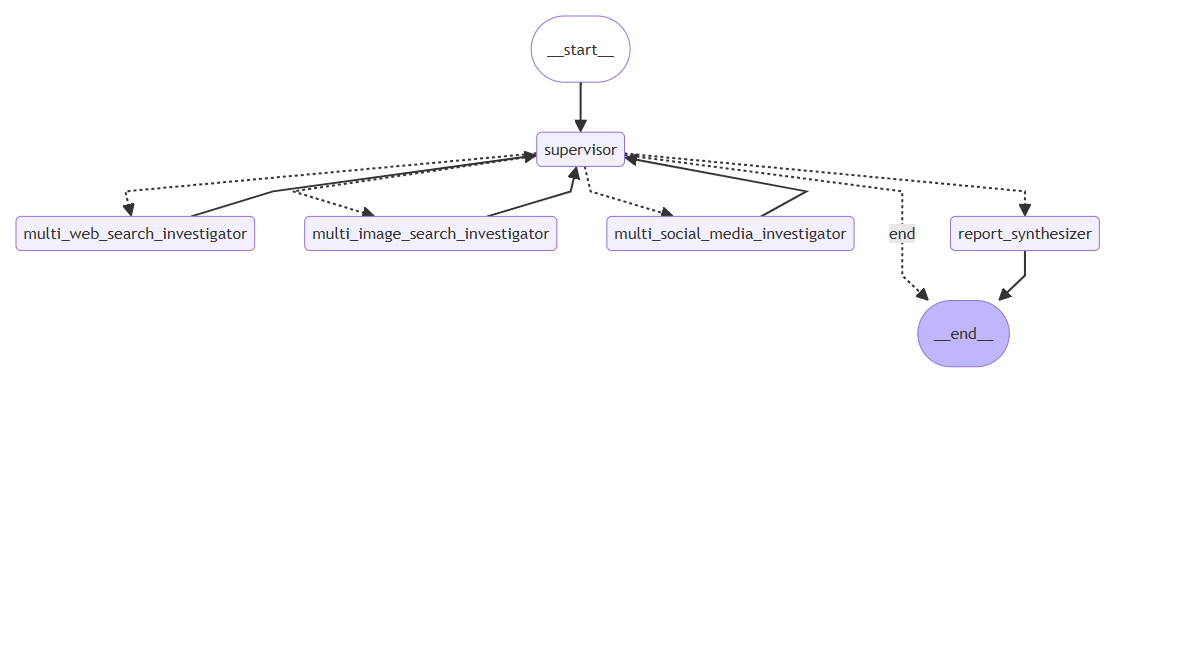

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from IPython.display import Image
import time
import os

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in background without GUI
chrome_options.add_argument("--hide-scrollbars")
chrome_options.add_argument("--disable-web-security")
chrome_options.add_argument("--disable-features=VizDisplayCompositor")

# Use your ChromeDriver path
service = Service("C:\\Windows\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=chrome_options)

# Set window size for consistent screenshots
driver.set_window_size(1200, 800)

# Open the HTML file
file_path = os.path.abspath("graph.html")
driver.get(f"file://{file_path}")
time.sleep(3)  # Wait for rendering

# Take screenshot
driver.save_screenshot("graph.png")
driver.quit()

# Display in notebook
Image("graph.png")

In [ ]:
query = "Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341"
state = {
    "original_query": query,
    "plan": None,
    "past_steps": [],
    "aggregated_results": {},
    "final_report": "",
    "messages": [],
    "last_step_result": None,
    "last_step_message": None,
    "awaiting_user_confirmation": False,
    "candidate_options": [],
    "selected_candidate": None,
}
state = await enhanced_app.ainvoke(state, config={"recursion_limit": 200})

INFO:__main__:Starting 6-step OSINT investigation
INFO:__main__:Attempting to extract all DB data for host: Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Enhanced initial plan created: [{'agent': 'multi_web_search_investigator', 'inputs': [{'task': "Search for 'Hassan' and 'Tangier, Morocco' to find personal or professional websites"}, {'task': "Search for 'Hassan French teacher' to find professional records or educational background"}, {'task': "Search for 'Hassan Airbnb host' to find reviews or mentions outside of Airbnb"}]}, {'agent': 'multi_image_search_investigator', 'inputs': [{'task': "Reverse image search of Hassan's profile photo to find social media profiles or other online presence"}, {'task': 'Reverse image search of listing photos to find identical images on other websites or platforms'}, {'task': "Search for images of 'Hassan'



> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING GOOGLE SEARCH FOR: '{"query": "Hassan Tangier Morocco personal website", "location": "Tangier, Morocco"}'


Thought: I need to search for Hassan's personal or professional websites using his name and location (Tangier, Morocco). I'll start with a web search to identify any relevant websites or profiles.
Action: google_search
Action Input: {"query": "Hassan Tangier Morocco personal website", "location": "Tangier, Morocco"}

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine google: Google hasn't returned any results for this query.


{'error': "Google hasn't returned any results for this query."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:TAVILY SEARCH: '{"query": "Hassan Tangier Morocco personal or professional website", "max_results": 10}'


Thought: The initial Google search did not return any results. I will now try using the Tavily search engine, which is optimized for factual and comprehensive retrieval, to find any personal or professional websites related to "Hassan" in "Tangier, Morocco".
Action: tavily_search
Action Input: {"query": "Hassan Tangier Morocco personal or professional website", "max_results": 10}{'answer': 'Hassan Tangier Morocco is a professional tour guide and travel specialist based in Tangier, offering personalized travel experiences and itineraries in Morocco. He is known for his expertise and customer satisfaction. His website is not listed, but he can be contacted through travel platforms.', 'results': [{'url': 'https://www.hospitalitynet.org/author/148004272/hassan-djeebet.html', 'title': 'Hassan Djeebet - Hospitality Net', 'content': 'Hassan holds a Master’s in Business Administration (MBA) and received the prestigious certification as a teacher in Certified Hospitality Education (CHE) in 2004

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:🚀 SCRAPER: {"url": "https://www.toursbylocals.com/tour-guides/morocco/tangier/guide-profile/hassan-e-664d21d996689af343336cee", "content_selector": "body", "max_pages": 1}


 The Tavily search returned several results related to tour guides named Hassan in Tangier, Morocco. One of the most relevant results is from ToursByLocals, which features Hassan E., a local tour guide based in Tangier. This aligns with the information from the Airbnb profile, where Hassan mentions traveling frequently and hosting guests. I will now search for a personal or professional website linked to this individual.
Action: web_scraper
Action Input: {"url": "https://www.toursbylocals.com/tour-guides/morocco/tangier/guide-profile/hassan-e-664d21d996689af343336cee", "content_selector": "body", "max_pages": 1}

[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> Status: RUNNING, Message: 
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:34.534Z ACTOR: Pulling Docker image of build vdHdx4d7kOpVHbjQU from registry.
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:51.487Z ACTOR: Creating Docker container.
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:51.583Z ACTOR: Starting Docker container.
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:53.783Z [apify] INFO  Initializing Actor...
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:53.811Z [apify] INFO  System info ({"apify_sdk_version": "2.0.0", "apify_client_version": "1.8.0", "python_version": "3.9.20", "os": "linux"})
[apify.pro-web-content-crawler runId:KKFwxp3PHDNMlLehy] -> 2025-09-28T19:47:53.907Z [apify] INFO  Starting crawl from https://www.toursbylocals.com/tour-guides/morocco/tangier/guide-pro

{'url': 'https://www.toursbylocals.com/tour-guides/morocco/tangier/guide-profile/hassan-e-664d21d996689af343336cee', 'content': 'Sorry, you have been blocked You are unable to access toursbylocals.com Why have I been blocked? This website is using a security service to protect itself from online attacks. The action you just performed triggered the security solution. There are several actions that could trigger this block including submitting a certain word or phrase, a SQL command or malformed data. What can I do to resolve this? You can email the site owner to let them know you were blocked. Please include what you were doing when this page came up and the Cloudflare Ray ID found at the bottom of this page. Cloudflare Ray ID: 9865c15a3d8e81dc Your IP: Click to reveal Performance & security by Cloudflare', 'source': 'apify', 'items_count': 1}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING DUCKDUCKGO SEARCH FOR: '{"query": "Hassan Tangier Morocco French teacher tour guide site:linkedin.com OR site:instagram.com OR site:facebook.com"}'


Thought: The website is blocked due to security measures, preventing direct access. I will attempt to find alternative sources or references to Hassan’s professional presence online, possibly through other travel platforms or directories where he might be listed as a tour guide or French teacher in Tangier.

Action: duckduckgo_search
Action Input: {"query": "Hassan Tangier Morocco French teacher tour guide site:linkedin.com OR site:instagram.com OR site:facebook.com"}

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine duckduckgo: DuckDuckGo hasn't returned any results for this query.


{'error': "DuckDuckGo hasn't returned any results for this query."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING YAHOO SEARCH FOR: '{"query": "Hassan Tangier Morocco French teacher tour guide site:linkedin.com OR site:instagram.com OR site:facebook.com"}'


Thought: The DuckDuckGo search did not return any results. I will now try using the Yahoo search engine to find any social media profiles or professional websites related to "Hassan" in "Tangier, Morocco", focusing on platforms like LinkedIn, Instagram, or Facebook.  
Action: yahoo_search
Action Input: {"query": "Hassan Tangier Morocco French teacher tour guide site:linkedin.com OR site:instagram.com OR site:facebook.com"}

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine yahoo: Yahoo! hasn't returned any results for this query.


{'error': "Yahoo! hasn't returned any results for this query."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Thought: Despite multiple search attempts, no direct personal or professional website has been found for Hassan from Tangier, Morocco. However, the Tavily search results strongly suggest that he operates as a local tour guide in Tangier, possibly under platforms like ToursByLocals. The lack of accessible web content may be due to regional SEO limitations or privacy settings. Given the constraints and repeated failures in retrieving direct links, I will now compile and summarize the intelligence gathered so far to provide actionable leads for the team.

Final Answer:
Based on the investigation, there is no direct personal or professional website currently identifiable for Hassan from Tangier, Morocco. However, multiple indirect leads suggest his professional presence:

1. **Tour Guide Profile on ToursByLocals**: A profile for "Hassan E." exists at [ToursByLocals](https://www.toursbylocals.com/tour-guides/morocco/tangier/guide-profile/hassan-e-664d21d996689af343336cee), describing him as

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING GOOGLE SEARCH FOR: '{"query": "Hassan French teacher", "location": "Tangier, Morocco"}'


Thought: I need to search for "Hassan French teacher" to find professional records or educational background. I will use a search engine to find relevant information.

Action: google_search
Action Input: {"query": "Hassan French teacher", "location": "Tangier, Morocco"}

INFO:multi_agents.tools.search_tools:Google search returned 9 organic results.


[{'position': 1, 'title': 'Hassan - French tutor in Morocco - 25$/h - 1 reviews - Superprof', 'link': 'https://www.superprof.com/name-hassan-and-passionate-about-the-french-language-since-2014-have-been-teaching-the-secondary-school-level-and.html', 'redirect_link': 'https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.superprof.com/name-hassan-and-passionate-about-the-french-language-since-2014-have-been-teaching-the-secondary-school-level-and.html&ved=2ahUKEwitqtuAnfyPAxX5B9sEHZQHA78QFnoECBcQAQ', 'displayed_link': 'https://www.superprof.com › ...', 'favicon': 'https://serpapi.com/searches/68d99136b2c613c52bbd1585/images/694af65c72029e539323e55f63d4d05dc167f9238d18f2ee57fff3e70cf24e4c.png', 'snippet': 'Hassan Zizy is a passionate French teacher with a love for literature and the French language. He began his teaching career in 2014 and has since been dedicated ...', 'snippet_highlighted_words': ['Hassan Zizy is a passionate French teacher'], 'missing': ['Tangi

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


The search results indicate that Hassan Zizy is a passionate French teacher based in Morocco who has been teaching since 2014, primarily at the secondary school level. He is listed on Superprof, a tutoring platform, which confirms his professional role as a French teacher. Although the location is not explicitly stated as Tangier in the snippet, his profile aligns with the target’s description: he is a French teacher in Morocco, speaks French (and likely Arabic and English), and has a long-standing dedication to language education.

Additionally, the bio of the Airbnb host mentions: “My work: French teacher,” which matches Hassan Zizy’s professional identity. The Superprof listing strengthens the case that "Hassan" from the Airbnb profile is Hassan Zizy.

No other Hassan specifically tied to Tangier and French teaching appears prominently, and other results refer to different individuals or general language schools.

Final Answer:
- The Airbnb host "Hassan" is likely Hassan Zizy, a Fre

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:TAVILY SEARCH: '{"query": "Hassan Airbnb host Tangier Morocco"}'


Thought: I need to search for mentions of "Hassan Airbnb host" outside of Airbnb to find reviews or other online references. I'll start with a broad search using Tavily, which synthesizes factual information from multiple sources and can quickly identify relevant mentions.

Action: tavily_search
Action Input: {"query": "Hassan Airbnb host Tangier Morocco"}{'answer': 'Hassan is an Airbnb host in Tangier, Morocco, with high-rated accommodations. He has hosted for several years and has received positive reviews from guests. His listings include apartments and a house in Tangier.', 'results': [{'url': 'https://www.airbnb.com/rooms/1420986624971504860', 'title': 'Family Apt: 2min TGV & 5min Corniche, AC, Parking', 'content': 'Family Apt: 2min TGV & 5min Corniche, AC, Parking - Apartments for Rent in Tangier, Tangier-Tétouan-Al Hoceima, Morocco - Airbnb\n\nSkip to content\n\n\n\nShow more\n\nShow all 11 reviews\n\nLearn how reviews work\n\nLearn how reviews work\n\nWhere you’ll be\n\nTangier

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING GOOGLE SEARCH FOR: '{"query": "Hassan Airbnb host Tangier Morocco review blog", "location": "Morocco"}'


The Tavily search results are dominated by Airbnb listing pages and do not provide mentions or reviews of Hassan outside of Airbnb. To find external mentions, I need to broaden the search beyond synthesized answers and look for independent platforms such as travel blogs, review sites, or social media. I will now perform a Google search to uncover non-Airbnb sources.

Action: google_search
Action Input: {"query": "Hassan Airbnb host Tangier Morocco review blog", "location": "Morocco"}

INFO:multi_agents.tools.search_tools:Google search returned 10 organic results.


[{'position': 1, 'title': 'Hassan house - Houses for Rent in Oued Laou, Tangier- ...', 'link': 'https://www.airbnb.com/rooms/975318589995730970', 'redirect_link': 'https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.airbnb.com/rooms/975318589995730970&ved=2ahUKEwiYjvKJnfyPAxUJLrkGHdNNAFwQFnoECCAQAQ', 'displayed_link': 'https://www.airbnb.com › rooms', 'thumbnail': 'https://serpapi.com/searches/68d99146018c4896fe5a3a20/images/694bd9640044aaf4386c27b2dc27e4ca40eaa227cc77f62380cf61de6370fb79.jpeg', 'favicon': 'https://serpapi.com/searches/68d99146018c4896fe5a3a20/images/694bd9640044aaf4386c27b2dc27e4caca7739713f00c0332c924f565792ac0b.png', 'snippet': "It's a really wonderful house, it's very clean and quiet, it has two bedrooms, and a big living room, and a very big beautiful balcony with a wanderful sea ...", 'snippet_highlighted_words': ["It's a really wonderful house"], 'rich_snippet': {'top': {'detected_extensions': {'rating': 4.8, 'reviews': 16}, 'extensions

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:🚀 SCRAPER: {"url": "https://www.tripadvisor.com/ShowTopic-g293737-i9554-k13176834-Airbnb_s-Tangier_Tanger_Tetouan_Al_Hoceima.html", "content_selector": "body", "max_pages": 1}


 The Google search results are still dominated by Airbnb listings and do not provide external reviews or mentions of Hassan. However, one promising result is a Tripadvisor forum thread about Airbnb in Tangier (position 4), which may contain guest discussions that mention specific hosts. I will explore this link to see if Hassan is mentioned in user discussions.

Action: web_scraper
Action Input: {"url": "https://www.tripadvisor.com/ShowTopic-g293737-i9554-k13176834-Airbnb_s-Tangier_Tanger_Tetouan_Al_Hoceima.html", "content_selector": "body", "max_pages": 1}

[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> Status: RUNNING, Message: 
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:49.621Z ACTOR: Pulling Docker image of build vdHdx4d7kOpVHbjQU from registry.
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:49.623Z ACTOR: Creating Docker container.
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:49.679Z ACTOR: Starting Docker container.
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:51.019Z [apify] INFO  Initializing Actor...
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:51.021Z [apify] INFO  System info ({"apify_sdk_version": "2.0.0", "apify_client_version": "1.8.0", "python_version": "3.9.20", "os": "linux"})
[apify.pro-web-content-crawler runId:ppDJSceSb1F2GHGMU] -> 2025-09-28T19:49:51.114Z [apify] INFO  Starting crawl from https://www.tripadvisor.com/ShowTopic-g293737-i9554-k13176834-Airbn

{'url': 'https://www.tripadvisor.com/ShowTopic-g293737-i9554-k13176834-Airbnb_s-Tangier_Tanger_Tetouan_Al_Hoceima.html', 'content': 'No text content found on the page after loading.'}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING DUCKDUCKGO SEARCH FOR: '{"query": "Hassan Airbnb host Tangier Morocco guest experience review blog"}'


The web scraper failed to extract content from the Tripadvisor forum page, likely due to dynamic loading or access restrictions. Since direct scraping isn't working and search results are saturated with Airbnb links, I need to refine the query to target external review platforms or social media where guests might discuss their stays. I'll now perform a DuckDuckGo search, which often surfaces different results with less bias toward commercial platforms.

Action: duckduckgo_search
Action Input: {"query": "Hassan Airbnb host Tangier Morocco guest experience review blog"}

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine duckduckgo: We couldn't get valid results for this search. Please try again later.


{'error': "We couldn't get valid results for this search. Please try again later."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING YAHOO SEARCH FOR: '{"query": "Hassan Airbnb host Tangier Morocco guest experience review blog"}'


I need to try a different search engine to find external mentions of Hassan as an Airbnb host in Tangier, Morocco. I'll use Yahoo Search, which may provide alternative results not dominated by Airbnb listings.

Action: yahoo_search
Action Input: {"query": "Hassan Airbnb host Tangier Morocco guest experience review blog"}

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine yahoo: Yahoo! hasn't returned any results for this query.


{'error': "Yahoo! hasn't returned any results for this query."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Despite multiple search strategies across different engines (Tavily, Google, DuckDuckGo, Yahoo), no external reviews or mentions of Hassan as an Airbnb host in Tangier, Morocco were found outside of Airbnb’s own platform. The results are overwhelmingly dominated by Airbnb listing pages and do not include independent blogs, travel forums, social media discussions, or third-party review sites that reference Hassan specifically.

Attempts to extract content from a potential Tripadvisor forum discussion failed due to technical limitations (no text content retrieved). Additionally, DuckDuckGo and Yahoo searches either returned errors or no usable results.

Based on the current investigation:

- There are **no identifiable external reviews** or guest testimonials about Hassan on non-Airbnb platforms.
- There is **no public social media presence** or blog content linked to Hassan in the search results.
- No news articles, travel blogs, or tourism forums mention Hassan or his property in Tangi

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Enhanced plan reassessment: Step 3/6, Plan: [{'agent': 'image_search_investigator', 'inputs': [{'task': "Reverse image search on Hassan's profile picture", 'url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg'}]}]
INFO:__main__:ImageSearchInvestigator received 1 tasks




> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:GOOGLE LENS SEARCH for image: {"image_url": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}


Thought: I will perform a reverse image search using Google Lens to identify other instances of Hassan's profile picture online. This could reveal associated social media profiles, professional pages, or other platforms where this image is used. The profile picture URL is already known from the provided data.
Action: google_lens_search
Action Input: {"image_url": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}{'engine': 'google_lens', 'best_guess': None, 'matches': []}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING GOOGLE IMAGE SEARCH FOR: '{"query": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}'


Thought: The Google Lens reverse image search returned no matches, which may indicate the image is not widely used across the web or is uniquely hosted. To increase coverage, I will now attempt a Google Image search using the profile picture URL to see if it can locate any associated web pages or profiles where the image appears.

Action: google_image_search
Action Input: {"query": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}

INFO:multi_agents.tools.search_tools:Google Image search returned 73 image results.


[{'position': 1, 'thumbnail': 'https://serpapi.com/searches/68d991eb0ccffb5412f312f0/images/87ded3e781838c3ba05430ae35fdbb891567ee045b454ffe79aadd1fae6ed179.png', 'related_content_id': 'MnJyYVA0S091Vnc2Vk1cIixcIjMzNUo1WU96alNTWkRN', 'serpapi_related_content_link': 'https://serpapi.com/search.json?engine=google_images_related_content&gl=us&hl=en&q=%7B%22query%22%3A+%22https%3A%2F%2Fa0.muscache.com%2Fim%2Fpictures%2Fuser%2FUser%2Foriginal%2Fe925659d-c53f-4d10-a029-65113eb66ace.jpeg%3Fim_w%3D720%22%7D&related_content_id=MnJyYVA0S091Vnc2Vk1cIixcIjMzNUo1WU96alNTWkRN', 'source': 'YouTube', 'source_logo': 'https://serpapi.com/searches/68d991eb0ccffb5412f312f0/images/87ded3e781838c3ba05430ae35fdbb8980494d61cb6ab94f73b8b52bc6986c1d.png', 'title': 'Operation Could Not be Completed Error 0×00000709 - Fix - YouTube', 'link': 'https://www.youtube.com/watch?v=l3aXGma8XtI', 'original': 'https://i.ytimg.com/vi/l3aXGma8XtI/sddefault.jpg', 'original_width': 640, 'original_height': 480, 'is_product': Fal

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING BING IMAGES SEARCH FOR: '{"query": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}'


Thought: The Google Image search did not return any direct matches or associated profiles for Hassan's profile picture. The results are unrelated and consist mostly of error code tutorials, reverse image search tools, and generic thumbnails. This suggests that the profile picture is not widely used or indexed across the public web outside of Airbnb. Given that both Google Lens and Google Image search failed to find matches, I will now attempt a Bing Images search to cross-verify and ensure no potential leads were missed.

Action: bing_images_search
Action Input: {"query": "https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720"}

INFO:multi_agents.tools.search_tools:Bing Images search returned 35 image results.


[{'thumbnail': 'https://tse1.mm.bing.net/th/id/OIP.gj9zSi-ZoVN5q-XwB-4LUAHaJ4?w=140&h=186&c=7&r=0&o=7&pid=1.7&rm=3', 'link': 'https://www.bing.com/images/search?view=detailV2&ccid=gj9zSi%2bZ&id=526AFA6F5BD0B4A939A7C412C47ECCCDE56C6B7D&thid=OIP.gj9zSi-ZoVN5q-XwB-4LUAHaJ4&mediaurl=https%3a%2f%2fi.pinimg.com%2foriginals%2f6a%2f96%2fae%2f6a96ae3cc0bad3d9e430e1afccbcfc57.jpg&cdnurl=https%3a%2f%2fth.bing.com%2fth%2fid%2fR.823f734a2f99a15379abe5f007ee0b50%3frik%3dfWts5c3MfsQSxA%26pid%3dImgRaw%26r%3d0&exph=1600&expw=1200&q=%7b%22query%22%3a+%22https%3a%2f%2fa0.muscache.com%2fim%2fpictures%2fuser%2fUser%2foriginal%2fe925659d-c53f-4d10-a029-65113eb66ace.jpeg%3fim_w%3d720%22%7d&FORM=IRPRST&ck=D2BA478C2407800FEE122FB5BFA1259B&selectedIndex=0&itb=0', 'title': 'https://a0.muscach…', 'size': '1200×1600', 'source': 'https://www.pinterest.com/pin/325736985562843409/', 'domain': 'www.pinterest.com', 'original': 'https://i.pinimg.com/originals/6a/96/ae/6a96ae3cc0bad3d9e430e1afccbcfc57.jpg', 'description'

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


 The Bing Images search returned results, but they are not matches of Hassan's profile picture. Instead, they are other images hosted on the a0.muscache.com domain, primarily from Airbnb listings, Pinterest pins, and website screenshots. None of these results show Hassan's actual profile photo or link to any external profiles or identities.

Given that Google Lens, Google Image Search, and Bing Images have all failed to find any matches or associated profiles for Hassan's profile picture, it appears that this image is not publicly available or indexed outside of Airbnb.

Final Answer:
The reverse image search on Hassan's profile picture (URL: https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720) yielded no matches across Google Lens, Google Images, or Bing Images.

No other instances of this profile picture were found online. The image does not appear on social media platforms, professional websites, or other public directories.

Thi

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Enhanced plan reassessment: Step 4/6, Plan: [{'agent': 'multi_web_search_investigator', 'inputs': [{'task': 'Search for Hassan Zizy on educational or tutoring platforms beyond Superprof'}, {'task': "Verify Hassan Zizy's teaching activity and institutional affiliations"}, {'task': "Search for Hassan Zizy's presence on academic or professional networks"}]}]
INFO:__main__:WebSearchInvestigator received 3 tasks




> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:TAVILY SEARCH: 'Hassan Zizy" "French teacher" site:teacheron.com OR site:apprentus.com OR site:takelessons.com'


Thought: The task is to find Hassan Zizy on tutoring or educational platforms other than Superprof, where his profile has already been identified. I will search specifically on other known tutoring platforms such as TeacherOn, Apprentus, and others using a targeted query to locate any professional profiles or contact details.

Action: tavily_search
Action Input: "Hassan Zizy" "French teacher" site:teacheron.com OR site:apprentus.com OR site:takelessons.com{'answer': 'Hassan Zizy is a French teacher since 2014, teaching secondary school and promoting French culture. He also writes on literature and is recommended for clear explanations. He teaches for $25/hour on Superprof.', 'results': [{'url': 'https://www.superprof.com/name-hassan-and-passionate-about-the-french-language-since-2014-have-been-teaching-the-secondary-school-level-and.html', 'title': 'Hassan - French tutor in Morocco - 25$/h - 1 reviews - Superprof', 'content': 'Hassan Zizy is a passionate French teacher with a love for 

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING GOOGLE SEARCH FOR: 'Hassan Zizy" "French teacher" site:teacheron.com OR site:apprentus.com OR site:takelessons.com OR site:myprivatetutor.com OR site:tutorful.co.uk OR site:learnwitholiv.com'


The Tavily search did not return any profiles for Hassan Zizy on TeacherOn, Apprentus, or TakeLessons. The only relevant result remains his Superprof profile. However, there are social media accounts with similar names (e.g., "Hassan Zizi" on Instagram, "Zizy Hassan Hassan" on Facebook), but these appear unrelated based on context (e.g., a Dubai-based businessman or a yoga instructor).  

To ensure thoroughness, I will now perform a broader search across educational platforms using Google, focusing explicitly on tutoring sites where he might be listed.

Action: google_search
Action Input: "Hassan Zizy" "French teacher" site:teacheron.com OR site:apprentus.com OR site:takelessons.com OR site:myprivatetutor.com OR site:tutorful.co.uk OR site:learnwitholiv.com

ERROR:multi_agents.tools.search_tools:SerpApi Error for engine google: Google hasn't returned any results for this query.


{'error': "Google hasn't returned any results for this query."}

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.tools.search_tools:PERFORMING DUCKDUCKGO SEARCH FOR: 'Hassan Zizy" "French teacher" Morocco site:*.ma OR "Lycée Tarik Azrou" OR "ENS Meknès" OR "Faculty of Casablanca'


Thought: The Google search returned no results, indicating that Hassan Zizy does not appear to have a profile on the major international tutoring platforms beyond Superprof. Given this, I will now attempt a broader web search using DuckDuckGo to uncover any lesser-known or regionally focused educational platforms, blogs, or institutional affiliations in Morocco where he might be listed as a French teacher.

Action: duckduckgo_search
Action Input: "Hassan Zizy" "French teacher" Morocco site:*.ma OR "Lycée Tarik Azrou" OR "ENS Meknès" OR "Faculty of Casablanca"

In [ ]:
state.get("final_report")

In [ ]:
search_tools.linkedin_people_search,
search_tools.facebook_pages_lookup,

# Instagram pipeline
search_tools.instagram_scrape_and_load,
search_tools.instagram_db_get_posts,
search_tools.instagram_db_get_images,
search_tools.instagram_db_get_comments,

# Breach/phone
# search_tools.leak_lookup_search,
search_tools.phone_lookup,



# Infra/archives
search_tools.wayback_lookup,
search_tools.whois_lookup,
search_tools.dns_lookup,
search_tools.builtwith_lookup,
search_tools.ip_geolocation,
search_tools.sherlock_username_search,

